## Prepare drones

### Luftronix

#### Preprocess and store as tiles

In [2]:
import json
import os
import shutil
import cv2
from typing import Union, Optional
import os
import rasterio
import os
import pandas as pd
from tqdm import tqdm


In [3]:
LUFTRONIX_RAW = "/home/topkech/work/sat_datasets/cross-domain-raw/luftronix"
camera_params_folder = '/app/nas/drones/camera_params'
dem_path = '/app/nas/DEM/aster_dem_parts'
tiles_path = '/app/nas/drones/tiles/COCO'


In [4]:
cam_params = dict()
for name in os.listdir(camera_params_folder):
    with open(os.path.join(camera_params_folder, name), 'r') as rf:
        params = json.load(rf)
        cam_params[params['width']] = params


In [5]:
FRAMES_FILENAME = 'Frames.csv'
GPS_FILENAME = 'GPS.csv'
POS_FILENAME = 'LocalPose.csv'
DEFAULT_ALTITUDE = 100

def calculate_alt(row, col, dem):
    _, s_x, s_y = dem.shape
    if row > 0 and col > 0 and col < s_x and row < s_y:
        a = dem[0, row, col]
        return a
    else:
        return None


def read_dem_data(lon, lat, data_folder):
    dem_data = {}
    for i in os.listdir(data_folder):
        name = i.split('_')
        name_part = name[0] + '_' + name[1]
        row = -1
        col = -1
        if name[-1] == 'num.tif':
            num_p = os.path.join(data_folder, i)
            num = rasterio.open(num_p)
            row, col = num.index(lon, lat)
            dem_name = name_part + '_dem.tif'
            dem_p = os.path.join(data_folder, dem_name)
            dem = rasterio.open(dem_p)
            dem = dem.read()
            _, s_x, s_y = dem.shape
            if row > 0 and col > 0 and col < s_x and row < s_y:
                dem_data['num'] = num
                dem_data['dem'] = dem
                return dem_data
    return None

def get_alt(lon: Union[float, int],
            lat: Union[float, int],
            data_folder: str,
            data_img: Optional[dict]) -> float:
    if data_img is None:
        data_img = read_dem_data(lon, lat, data_folder)
    if data_img is not None:
        num = data_img["num"]
        dem = data_img["dem"]
        row, col = num.index(lon, lat)
        alt = calculate_alt(row, col, dem)
        if alt is not None:
            return alt
    return DEFAULT_ALTITUDE


def calculate_dem_elevation_df_from_dir(df, dem_dir):
    first_lon, first_lat = df[['longitude', 'latitude']].iloc[0].tolist()

    dem_data_dict = read_dem_data(first_lon, first_lat, dem_dir)
    dem_alts = df.apply(lambda x: get_alt(x['longitude'], x['latitude'], dem_dir, dem_data_dict), axis=1)
    return dem_alts


def get_elevation_df(raw_imgs_folder, dem_map_dir):

    frames_df = pd.read_csv(os.path.join(raw_imgs_folder, FRAMES_FILENAME), sep=';')
    gps_df = pd.read_csv(os.path.join(raw_imgs_folder, GPS_FILENAME), sep=';')
    rpy_df = pd.read_csv(os.path.join(raw_imgs_folder, POS_FILENAME), sep=';')

    frames_df.sort_values(by='timeNS', inplace=True, ascending=True)
    gps_df.sort_values(by='timeNS', inplace=True, ascending=True)
    rpy_df.sort_values(by='timeNS', inplace=True, ascending=True)

    gps_df = pd.merge_asof(gps_df, rpy_df, on='timeNS', direction='nearest')
    frames_df = pd.merge_asof(frames_df, gps_df, on='timeNS', direction='nearest')

    images_names_in_folder = set([filename for filename in os.listdir(raw_imgs_folder) if filename.endswith('.png')])
    images_names_in_csv = set(frames_df['filename'])
    missing_imgs = images_names_in_folder.difference(images_names_in_csv)

    if len(missing_imgs) > 0:
        raise ValueError(f'some images are presented in input folder but missing from the {FRAMES_FILENAME}: {missing_imgs}')

    dem_alt = calculate_dem_elevation_df_from_dir(frames_df, dem_map_dir)
    # dem_alt = calculate_dem_elevation_df_from_dir(mission_data, dem_dir)
    frames_df['altitude'] = frames_df['altitude'] - dem_alt
    return frames_df


In [6]:
def get_gsd(focal, sensor_width, alt, img_w):
    gsd = (sensor_width*alt)/(focal*img_w)
    return gsd


In [7]:
longitude_train_thrs = 24.225


In [8]:
images_meta_tuples = []

cam_params_unsqueezed = []
for ds_name in tqdm(os.listdir(LUFTRONIX_RAW)[:]):

    ds_path = os.path.join(LUFTRONIX_RAW, ds_name)
    elevations = get_elevation_df(ds_path, dem_path)

    images_names = [el for el in os.listdir(ds_path) if el.endswith('.png')]
    image_height, image_width, _ = cv2.imread(os.path.join(ds_path, images_names[0])).shape

    ds_camera = cam_params[image_width]
    focal = ds_camera['focal']
    s_w = max(ds_camera['sensor_size'])

    for _, row in elevations.iterrows():
        if row['altitude'] < 50:
            continue
        gsd = get_gsd(focal, s_w, row['altitude'], image_width)
        if row['longitude'] > longitude_train_thrs:
            subset = 'train'
        else:
            subset = 'test'
        images_meta_tuples.append({
            'name': row['filename'],
            'path': os.path.join(ds_path, row['filename']),
            'dataset': ds_name,
            'gsd': gsd,
            'width': image_width,
            'subset': subset
        })


100%|██████████| 21/21 [00:14<00:00,  1.47it/s]


In [10]:
len([el for el in images_meta_tuples if el['subset']=='test']), len([el for el in images_meta_tuples if el['subset']=='train'])


(3997, 9684)

In [12]:
def downsample_to_gsd(image, image_gsd, target_gsd):
    def round2even(number: float):
        rounded_number = round(number)
        if rounded_number % 2 == 0:
            return rounded_number
        rounded_number = rounded_number + 1 if number > rounded_number else rounded_number - 1
        return rounded_number

    SUPERPOINT_INPUT_SHAPE = (320, 240)
    image_width, image_height = image.shape[1], image.shape[0]
    sp_width, sp_height = SUPERPOINT_INPUT_SHAPE
    drone_gsd_superpoint = image_gsd * image_width / sp_width

    active_w = (image_width / sp_width ) * (image_gsd / target_gsd ) * image_width
    active_h = (image_height / sp_height ) * (image_gsd / target_gsd ) * image_height
    active_w, active_h = round2even(active_w), round2even(active_h)
    if active_w > 4000 or active_h > 4000:
        return image
    if active_w < 5 or active_h < 5:
        return image
    image = cv2.resize(image, dsize=(active_w, active_h))
    return image

from PIL import Image

def slice_image_into_windows(image, window_width, window_height):
    img_height, img_width = image.shape[:2]
    windows = []

    for y in range(0, img_height, window_height):
        for x in range(0, img_width, window_width):
            if y+window_height>img_height or x+window_width > img_width:
                y_dist = max(0, y+window_height-img_height)
                x_dist = max(0, x+window_width-img_width)
                y = y - y_dist
                x = x - x_dist
            window = image[y:y+window_height, x:x+window_width]

            windows.append(window)

    return windows

import numpy as np

def fix_aspect_ratio_with_padding(image, relative_width, relative_height):
    img_height, img_width = image.shape[:2]
    aspect_ratio_width = img_width / relative_width
    aspect_ratio_height = img_height / relative_height

    if aspect_ratio_width == aspect_ratio_height:
        return image

    if aspect_ratio_width > aspect_ratio_height:
        target_width = img_width
        target_height = int(relative_height / relative_width * target_width)

        pad_top = (target_height - img_height) // 2
        pad_bottom = target_height - img_height - pad_top
        pad_left = 0
        pad_right = 0

    else:
        target_height = img_height
        target_width = int(relative_width / relative_height * target_height)

        pad_top = 0
        pad_bottom = 0
        pad_left = (target_width - img_width) // 2
        pad_right = target_width - img_width - pad_left

    padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), 'constant', constant_values=0)

    return padded_image

def random_crop(image, crop_width, crop_height):

    image_height, image_width, _ = image.shape

    if crop_height > image_height or crop_width > image_width:
        raise ValueError("Crop size cannot be larger than image size.")

    # Generate random top-left coordinates for the crop
    top = np.random.randint(0, image_height - crop_height + 1)
    left = np.random.randint(0, image_width - crop_width + 1)

    # Perform the crop using PIL
    pil_image = Image.fromarray(image)
    cropped_pil_image = pil_image.crop((left, top, left + crop_width, top + crop_height))

    return np.array(cropped_pil_image)


In [71]:
subfolders = {
    'train': os.path.join(tiles_path, 'train2014'),
    'test': os.path.join(tiles_path, 'val2014')
}

for subset, folder in subfolders.items():
    if not os.path.isdir(folder):
        os.mkdir(folder)


In [72]:
random_gsds = np.random.beta(2, 5, size=len(images_meta_tuples)).squeeze()*15
statuses = []
for image_meta, target_gsd in tqdm(zip(images_meta_tuples, random_gsds), total=len(images_meta_tuples)):
    image_gsd = image_meta['gsd']
    image_width = image_meta['width']
    image_path = image_meta['path']
    image_name = image_meta['name']
    dataset = image_meta['dataset']
    subset = image_meta['subset']
    superpoint_gsd = image_gsd * image_width / 320

    image = cv2.imread(image_path)
    if superpoint_gsd < target_gsd:
        choice = np.random.rand()
        if choice < 0.05:
            tiles = slice_image_into_windows(image, 320, 240)
            statuses.append('sliced')
        elif choice < 0.6:
            tiles = [random_crop(image, 320, 240)]
            statuses.append('cropped')
        else:
            downsampled_image = downsample_to_gsd(image, image_gsd, target_gsd)
            if downsampled_image.shape[0] > 240 and downsampled_image.shape[1] > 320:
                tiles = slice_image_into_windows(downsampled_image, 320, 240)
                statuses.append('downsampled_sliced')
            else:
                fixed_aspect_ratio_image = fix_aspect_ratio_with_padding(downsampled_image, 320, 240)
                tiles = [cv2.resize(fixed_aspect_ratio_image, dsize=(320, 240))]
                statuses.append('downsampled')

    else:
        downsampled_image = downsample_to_gsd(image, image_gsd, target_gsd)
        fixed_aspect_ratio_image = fix_aspect_ratio_with_padding(downsampled_image, 320, 240)
        tiles = [cv2.resize(fixed_aspect_ratio_image, dsize=(320, 240))]
        statuses.append('downsampled')

    tiles_subfolder = subfolders[subset]

    for tile_num, tile in enumerate(tiles):
        tile_name = f"tile{tile_num}-{image_name}-{dataset}.jpg"
        tile_path = os.path.join(tiles_subfolder, tile_name)
        cv2.imwrite(tile_path, tile)


100%|██████████| 13681/13681 [02:20<00:00, 97.18it/s] 


In [73]:
occurrence_count = {}
for element in statuses:
    occurrence_count[element] = occurrence_count.get(element, 0) + 1
occurrence_count


{'cropped': 6715,
 'downsampled': 4863,
 'downsampled_sliced': 1501,
 'sliced': 602}

In [74]:
len(os.listdir(subfolders['train'])),len(os.listdir(subfolders['test']))


(21133, 8615)

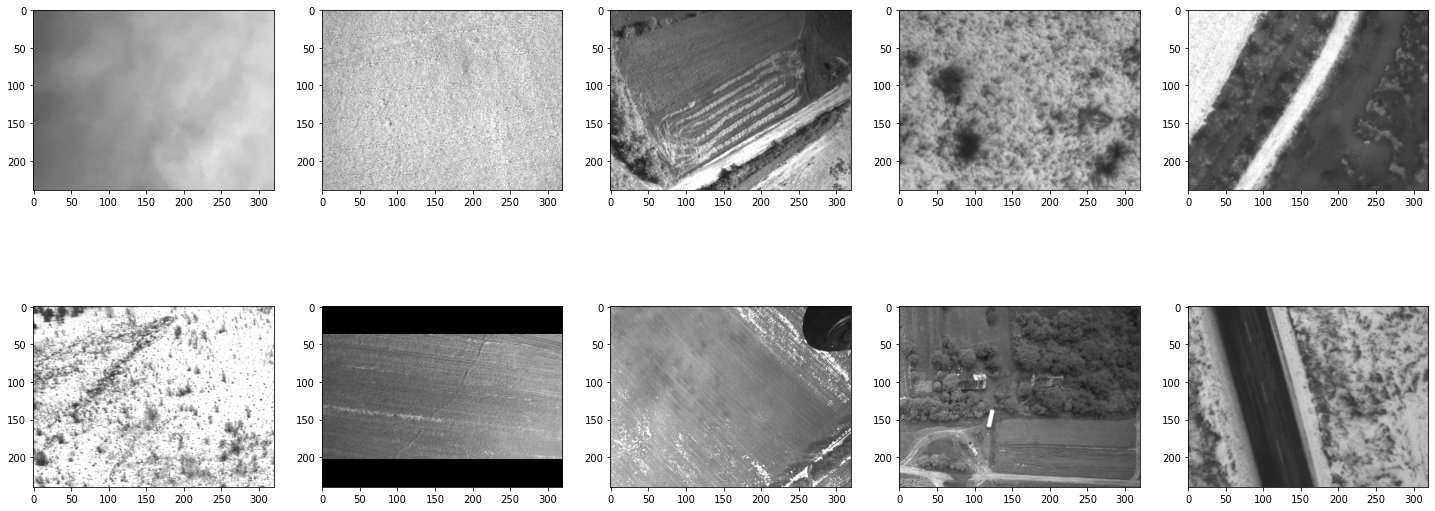

In [42]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(25, 10))
axs = axs.ravel()

for i, el in enumerate(os.listdir(tiles_subfolder)[100:110]):
    p = os.path.join(tiles_subfolder, el)
    im = cv2.imread(p)
    axs[i].imshow(im)


## Satellites

#### unzip some files

In [43]:
import zipfile
import os

def unzip_file(zip_file_path, destination_folder):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)

def unzip_all_in_folder(folder):
    for archive in tqdm(os.listdir(folder)):
        if archive.endswith('zip'):
            archive_path = os.path.join(folder, archive)
            archive_dest = archive_path.replace('.zip', '')
            unzip_file(archive_path, archive_dest)


In [279]:
# folders_with_zips = ['/app/nas/satellites/raw/PlanetScopeJune', '/app/nas/satellites/raw/Sentinel2June', '/app/nas/satellites/raw/SkySatJune']
# for f in folders_with_zips:
#     unzip_all_in_folder(f)


100%|██████████| 5/5 [01:17<00:00, 15.50s/it]


### Run slicing on 320x240

In [75]:
satellites_root = '/app/nas/satellites/raw'


In [76]:
satellites_filepaths = []
for root, _, files in os.walk(satellites_root):

    for file_name in files:
        file_path = os.path.join(root, file_name)

        if not (file_name.endswith('tif') or file_name.endswith('jp2')):
            continue

        if file_name.endswith('jp2') and not file_name.endswith('TCI.jp2'):
            continue
        if 'Planet' in file_path:
            satellite_type = 'PlanetScope'
        if 'SkyS' in file_path:
            satellite_type = 'SkySat'
        if 'Sentinel' in file_path:
            satellite_type = 'Sentinel'
        satellites_filepaths.append((satellite_type, file_path))


In [77]:
import os
import rasterio
from rasterio.windows import Window
from rasterio.plot import reshape_as_image

def read_raster_by_windows(input_path, output_dir, prefix, window_size=(320, 240)):
    basename = os.path.basename(input_path)
    windows = []
    xys = []
    with rasterio.open(input_path) as src:
        height, width = src.height, src.width

        for i in range(0, height, window_size[1]):
            for j in range(0, width, window_size[0]):
                window = Window(j, i, min(window_size[0], width - j), min(window_size[1], height - i))
                windows.append(window)
                xys.append((i, j))

        for window, (i, j) in tqdm(zip(windows, xys), total=len(windows), desc=f"{prefix}_{basename}"):
            data = src.read(window=window, boundless=True)[:3]
            if np.median(data) < 10:
                continue
            data = reshape_as_image(data)

            output_file = os.path.join(output_dir, f"{prefix}_{basename}_tile_{i}_{j}.jpg")

            data = cv2.cvtColor(data, cv2.COLOR_RGB2BGR)
            res = cv2.imwrite(output_file, data)


In [78]:
sat_destination = '/app/nas/satellites/tiles'
if os.path.exists(sat_destination):
    shutil.rmtree(sat_destination)
os.mkdir(sat_destination)


In [79]:
for sat_type, filepath in satellites_filepaths:
    read_raster_by_windows(filepath, sat_destination, prefix=sat_type)


PlanetScope_20230503_083627_36_247f_3B_Visual.tif:   5%|▌         | 86/1600 [00:00<00:05, 263.32it/s]

PlanetScope_20230503_083627_36_247f_3B_Visual.tif: 100%|██████████| 1600/1600 [00:14<00:00, 110.90it/s]
PlanetScope_20230726_081627_99_247a_3B_Visual.tif: 100%|██████████| 1521/1521 [00:13<00:00, 116.67it/s]
PlanetScope_20230726_081630_13_247a_3B_Visual.tif: 100%|██████████| 1521/1521 [00:13<00:00, 110.70it/s]
PlanetScope_20230604_080905_24_242e_3B_Visual.tif: 100%|██████████| 1764/1764 [00:16<00:00, 107.92it/s]
SkySat_20230623_102907_ssc17_u0001_visual.tif: 100%|██████████| 10810/10810 [01:38<00:00, 109.61it/s]
PlanetScope_20230607_081622_79_247c_3B_Visual.tif: 100%|██████████| 1443/1443 [00:11<00:00, 121.72it/s]
PlanetScope_20230607_081620_66_247c_3B_Visual.tif: 100%|██████████| 1443/1443 [00:11<00:00, 120.95it/s]
PlanetScope_20230620_073410_44_24b5_3B_Visual.tif: 100%|██████████| 1722/1722 [00:13<00:00, 123.81it/s]
PlanetScope_20230620_073408_12_24b5_3B_Visual.tif: 100%|██████████| 1722/1722 [00:14<00:00, 122.38it/s]
PlanetScope_20230622_074204_34_24c7_3B_Visual.tif: 100%|██████████

In [81]:
ss_count = len([el for el in os.listdir(sat_destination) if el.startswith('SkySat')])
ps_count = len([el for el in os.listdir(sat_destination) if el.startswith('Planet')])
s2_count = len([el for el in os.listdir(sat_destination) if el.startswith('Sentinel')])
print(ss_count, ps_count, s2_count)


63436 24421 14153


## Store all data in COCO

In [89]:
drone_tiles_path = '/app/nas/drones/tiles/COCO'
satellite_tiles_path = '/app/nas/satellites/tiles'
coco_path = '/app/nas/COCO'
if os.path.exists(coco_path):
    shutil.rmtree(coco_path)
os.mkdir(coco_path)


In [103]:
coco_original_path = '/app/nas/COCO_original'


In [90]:
print(os.listdir(os.path.join(drone_tiles_path, 'train2014'))[:3])
print(os.listdir(satellite_tiles_path)[:3])


['tile6-frame_1100.png-0070-frames.jpg', 'tile0-frame_2008.png-0070-frames.jpg', 'tile8-frame_480.png-0028-frames.jpg']
['SkySat_20230507_120356_ssc6_u0001_visual.tif_tile_10800_11520.jpg', 'Sentinel_T36TWS_20221115T085129_TCI.jp2_tile_6480_3840.jpg', 'SkySat_20230623_102907_ssc17_u0001_visual.tif_tile_3120_6080.jpg']


In [91]:
print(len(os.listdir(os.path.join(drone_tiles_path, 'train2014'))))
print(len(os.listdir(os.path.join(drone_tiles_path, 'val2014'))))
print(len(os.listdir(satellite_tiles_path)))


21133
8615
102010


In [92]:
source_subfolder = os.path.join(drone_tiles_path, 'train2014')
destination_subfolder = os.path.join(coco_path, 'train2014')

if os.path.exists(destination_subfolder):
    shutil.rmtree(destination_subfolder)
os.mkdir(destination_subfolder)

for el in tqdm(os.listdir(source_subfolder)):
    src = os.path.join(source_subfolder, el)
    dst = os.path.join(destination_subfolder, el)
    shutil.copy2(src, dst)


100%|██████████| 21133/21133 [05:34<00:00, 63.21it/s]


In [93]:
source_subfolder = os.path.join(drone_tiles_path, 'val2014')
destination_subfolder = os.path.join(coco_path, 'val2014')

if os.path.exists(destination_subfolder):
    shutil.rmtree(destination_subfolder)
os.mkdir(destination_subfolder)

for el in tqdm(os.listdir(source_subfolder)):
    src = os.path.join(source_subfolder, el)
    dst = os.path.join(destination_subfolder, el)
    shutil.copy2(src, dst)


100%|██████████| 8615/8615 [02:23<00:00, 60.17it/s]


In [101]:
print(len(os.listdir(os.path.join(coco_path, 'train2014'))))
print(len(os.listdir(os.path.join(coco_path, 'val2014'))))


21133
8615


In [102]:
# destination_subfolder = os.path.join(coco_path, 'train2014')

for tile_name in tqdm(os.listdir(satellite_tiles_path)):
    proba = np.random.rand()
    if proba < 0.75:
        destination_subfolder = os.path.join(coco_path, 'train2014')
    else:
        destination_subfolder = os.path.join(coco_path, 'val2014')

    src = os.path.join(satellite_tiles_path, tile_name)
    dst = os.path.join(destination_subfolder, tile_name)
    shutil.copy2(src, dst)


  0%|          | 60/102010 [00:00<11:58, 141.81it/s]

100%|██████████| 102010/102010 [11:44<00:00, 144.73it/s]


In [104]:
print(len(os.listdir(os.path.join(coco_path, 'train2014'))))
print(len(os.listdir(os.path.join(coco_path, 'val2014'))))


97774
33984


In [106]:
print(len(os.listdir(os.path.join(coco_original_path, 'train2014'))))
print(len(os.listdir(os.path.join(coco_original_path, 'val2014'))))


82783
40504


In [107]:
source_subfolder = os.path.join(coco_original_path, 'train2014')
destination_subfolder = os.path.join(coco_path, 'train2014')

for el in tqdm(os.listdir(source_subfolder)):
    proba = np.random.rand()
    if proba < 0.75:
        continue
    src = os.path.join(source_subfolder, el)
    dst = os.path.join(destination_subfolder, el)
    shutil.copy2(src, dst)


  2%|▏         | 1501/82783 [00:05<05:30, 245.71it/s]

100%|██████████| 82783/82783 [10:52<00:00, 126.96it/s]


In [108]:
source_subfolder = os.path.join(coco_original_path, 'val2014')
destination_subfolder = os.path.join(coco_path, 'val2014')

for el in tqdm(os.listdir(source_subfolder)):
    proba = np.random.rand()
    if proba < 0.75:
        continue
    src = os.path.join(source_subfolder, el)
    dst = os.path.join(destination_subfolder, el)
    shutil.copy2(src, dst)


100%|██████████| 40504/40504 [05:06<00:00, 131.96it/s]


In [110]:
print(len(os.listdir(os.path.join(coco_path, 'train2014'))))
print(len(os.listdir(os.path.join(coco_path, 'val2014'))))


118602
44220


In [137]:
logs_path = '/app/logs/magicpoint_synth_homoAdapt_coco/predictions'
print(len(os.listdir(os.path.join(logs_path, 'train'))))
print(len(os.listdir(os.path.join(logs_path, 'val'))))


118603
44221


# Cross-Domain

In [147]:
import pandas as pd
import numpy as np
import os
import shutil
import rasterio
from rasterio.windows import Window
from rasterio.plot import reshape_as_image
from rasterio.mask import mask
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from shapely.geometry import Polygon
import geopandas as gpd


### Process manual georeferenced images

In [150]:
georef_progress_path = '/app/nas/drones/manual_georeference/Manual_Georeferencing_Progress.csv'
completed_files_root  = '/app/nas/drones/manual_georeference/completed_files'

dataset_satellites = {
    'luftronix': [
        '/app/nas/drones/manual_georeference/all_used_satellites/S2A_MSIL1C_20221109T092211_N0400_R093_T34UGA_20221109T112315.SAFE/GRANULE/L1C_T34UGA_A038557_20221109T092343/IMG_DATA/T34UGA_20221109T092211_TCI.jp2',
        '/app/nas/drones/manual_georeference/all_used_satellites/SatNav_Lviv_2022-12-28_PS_psscene_visual/files/PSScene/20221228_085656_24_2475/visual/20221228_085656_24_2475_3B_Visual_modified.tif'
    ],
    'dji': ['/app/nas/drones/manual_georeference/all_used_satellites/djimini2_23_12_2022_large/djimini2_23_12_2022_large.tif'],
    'matrice': ['/app/nas/drones/manual_georeference/all_used_satellites/matrice_300_session_2/matrice_300_session_2.tif']
}

tiles_root = '/app/nas/drones/manual_georeference/tiles'
shutil.rmtree(tiles_root, ignore_errors=True)
os.mkdir(tiles_root)


In [174]:
tiles_drones = os.path.join(tiles_root, 'drones')
tiles_satellites = os.path.join(tiles_root, 'satellites')
shutil.rmtree(tiles_drones, ignore_errors=True)
shutil.rmtree(tiles_satellites, ignore_errors=True)
os.mkdir(tiles_drones)
os.mkdir(tiles_satellites)


In [175]:
georef_progress = pd.read_csv(georef_progress_path)
georef_progress.head(2)


,Dataset,Frame,Progress,Assigned to,Passed,Revised,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Done,Passed checks,Failed checks,initially bad photos
0,0028-frames,frame_217,True,Daria,True,TRUE,NaN,NaN,NaN,NaN,338.0,290.0,40.0,8.0
1,0028-frames,frame_218,True,NaN,True,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
georef_progress['Ready'] = georef_progress['Progress'] & georef_progress['Passed']
georef_progress['Ready'].sum()


290

In [177]:
georef_progress = georef_progress[georef_progress['Ready']].copy()
len(georef_progress)


290

In [178]:
def assign_area_by_dataset(dataset_name):
    if '-frames' in dataset_name:
        return 'luftronix'
    elif 'djimini' in dataset_name and dataset_name != 'djimini2_04_12_2022':  # djimini2_04_12_2022 is in other place, not needed
        return 'dji'
    elif 'matrice' in dataset_name:
        return 'matrice'
    else:
        return None


In [179]:
georef_progress['area_tag'] = georef_progress['Dataset'].apply(assign_area_by_dataset)
georef_progress.head(2)


,Dataset,Frame,Progress,Assigned to,Passed,Revised,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Done,Passed checks,Failed checks,initially bad photos,Ready,area_tag
0,0028-frames,frame_217,True,Daria,True,TRUE,NaN,NaN,NaN,NaN,338.0,290.0,40.0,8.0,True,luftronix
1,0028-frames,frame_218,True,NaN,True,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,luftronix


In [180]:
georef_progress = georef_progress[~georef_progress['area_tag'].isna()]


In [181]:
len(georef_progress)


283

In [182]:
georef_progress.tail()


,Dataset,Frame,Progress,Assigned to,Passed,Revised,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Done,Passed checks,Failed checks,initially bad photos,Ready,area_tag
540,matrice_300_session_2,DJI_20220504153105_0014_WIDE.tif,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,matrice
542,matrice_300_session_1,DJI_20220504144203_0002_WIDE.tif,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,matrice
543,matrice_300_session_1,DJI_20220504144330_0002_WIDE.tif,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,matrice
544,matrice_300_session_1,DJI_20220504144348_0002_WIDE.tif,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,matrice
545,matrice_300_session_1,DJI_20220504144516_0002_WIDE.tif,True,левый низ?,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,matrice


In [183]:
def find_file(root_dir, filename):
    if not filename.endswith('tif'):
        filename = filename + '.tif'

    root_dir = os.path.abspath(root_dir)
    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            if 'modified' not in fname:
                continue
            check_dupl = fname.replace('_modified', '_modified_modified')
            if '_modified' in fname and os.path.exists(os.path.join(dirpath, check_dupl)):
                fname = check_dupl

            if fname.replace('_modified', '') == filename:
                return os.path.join(dirpath, fname)
    return None

georef_progress['full_path'] = georef_progress.apply(lambda x: find_file(os.path.join(completed_files_root, x['Dataset']), x['Frame']), axis=1)
georef_progress.head(2)


,Dataset,Frame,Progress,Assigned to,Passed,Revised,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Done,Passed checks,Failed checks,initially bad photos,Ready,area_tag,full_path
0,0028-frames,frame_217,True,Daria,True,TRUE,NaN,NaN,NaN,NaN,338.0,290.0,40.0,8.0,True,luftronix,/app/nas/drones/manual_georeference/completed_...
1,0028-frames,frame_218,True,NaN,True,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,luftronix,/app/nas/drones/manual_georeference/completed_...


In [184]:
georef_progress[georef_progress['full_path'].isna()]


,Dataset,Frame,Progress,Assigned to,Passed,Revised,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Done,Passed checks,Failed checks,initially bad photos,Ready,area_tag,full_path


In [185]:
georef_progress_area.head(2)


,Dataset,Frame,Progress,Assigned to,Passed,Revised,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Done,Passed checks,Failed checks,initially bad photos,Ready,area_tag,full_path
539,matrice_300_session_2,DJI_20220504153049_0009_WIDE.tif,True,низ~,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,matrice,/app/nas/drones/manual_georeference/completed_...
540,matrice_300_session_2,DJI_20220504153105_0014_WIDE.tif,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,matrice,/app/nas/drones/manual_georeference/completed_...


In [186]:
total_its = 0
for area_name in dataset_satellites.keys():
    georef_progress_area = georef_progress[georef_progress['area_tag']==area_name].copy()
    for satellite_path in dataset_satellites[area_name]:
        total_its += len(georef_progress_area)

print(total_its)


531


In [187]:
with tqdm(total=total_its) as pbar:

    for area_name in dataset_satellites.keys():
        georef_progress_area = georef_progress[georef_progress['area_tag']==area_name].copy()
        for satellite_path in dataset_satellites[area_name]:
            sat_name = os.path.basename(satellite_path)

            with rasterio.open(satellite_path, 'r') as src_satellite:
                raster_crs = src_satellite.crs

                for _, row in georef_progress_area.iterrows():
                    drone_path = row['full_path']

                    with rasterio.open(drone_path, 'r') as src_drone:
                        bounds = src_drone.bounds
                        drone_img = src_drone.read().squeeze()
                        drone_crs = src_drone.crs

                    aoi_polygon = Polygon([
                        (bounds.left, bounds.bottom),
                        (bounds.right, bounds.bottom),
                        (bounds.right, bounds.top),
                        (bounds.left, bounds.top)
                    ])
                    if drone_crs != raster_crs:
                        aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_polygon], crs=drone_crs)
                        aoi_gdf.to_crs(raster_crs, inplace=True)
                        aoi_polygon = aoi_gdf['geometry'].iloc[0]

                    raster_crop, _ = mask(src_satellite, [aoi_polygon], crop=True, nodata=src_satellite.nodata, all_touched=True)
                    raster_crop = reshape_as_image(raster_crop)[:, :, :3]

                    raster_crop = cv2.cvtColor(raster_crop, cv2.COLOR_RGB2BGR)

                    tile_name = f"{row['area_tag']}_{sat_name}_{row['Dataset']}_{row['Frame']}.jpg"
                    drone_destination = os.path.join(tiles_drones, tile_name)
                    satel_destination = os.path.join(tiles_satellites, tile_name)

                    cv2.imwrite(drone_destination, drone_img)
                    cv2.imwrite(satel_destination, raster_crop)

                    pbar.update(1)


100%|██████████| 531/531 [00:43<00:00, 12.17it/s]


In [188]:
print(f"created {len(os.listdir(tiles_drones))} pairs")


created 531 pairs


### Create pairs for skysat

In [189]:
satellites_root = '/app/nas/satellites/raw'


In [190]:
satellites_filepaths = []
for root, _, files in os.walk(satellites_root):

    for file_name in files:
        file_path = os.path.join(root, file_name)

        if not (file_name.endswith('tif') or file_name.endswith('jp2')):
            continue

        if file_name.endswith('jp2') and not file_name.endswith('TCI.jp2'):
            continue
        if 'Planet' in file_path:
            satellite_type = 'PlanetScope'
        if 'SkyS' in file_path:
            satellite_type = 'SkySat'
        if 'Sentinel' in file_path:
            satellite_type = 'Sentinel'
        satellites_filepaths.append((satellite_type, file_path))


In [191]:
def change_poly_crs(polygon, crs1, crs2):
    gdf = gpd.GeoDataFrame(geometry=[polygon], crs=crs1)
    gdf.to_crs(crs2, inplace=True)
    polygon = gdf['geometry'].iloc[0]
    return polygon

def get_poly_crs(src):
    bounds = src.bounds
    crs = src.crs
    aoi_polygon = Polygon([
                (bounds.left, bounds.bottom),
                (bounds.right, bounds.bottom),
                (bounds.right, bounds.top),
                (bounds.left, bounds.top)
            ])
    return aoi_polygon, crs

def are_rasters_overlap(raster1_path, raster2_path):
    with rasterio.open(raster1_path) as src1:
        poly1, crs1 = get_poly_crs(src1)
    with rasterio.open(raster2_path) as src2:
        poly2, crs2 = get_poly_crs(src2)

    if crs1 != crs2:
        poly1 = change_poly_crs(poly1, crs1, crs2)

    return poly1.intersects(poly2) or poly1.overlaps(poly2) or poly2.overlaps(poly1)


In [192]:
skysat_files = [el for el in satellites_filepaths if el[0] == 'SkySat']
big_satel_files = [el for el in satellites_filepaths if el[0] != 'SkySat']
len(skysat_files), len(big_satel_files)


(13, 33)

In [193]:
skysat_other_pairs = []
for _, sky_path in skysat_files:
    for other_type, other_path in big_satel_files:
        if are_rasters_overlap(sky_path, other_path):
            skysat_other_pairs.append(
                (other_type, sky_path, other_path)
            )

len(skysat_other_pairs)


57

In [194]:
import rasterio
from rasterio.mask import mask


def get_coarse_polygon(raster_file_path):
    with rasterio.open(raster_file_path) as src:
        width = src.width
        height = src.height
        if src.res[0] < 1:
            block_size = 1_000
        elif src.res[0] < 4:
            block_size = 300
        else:
            block_size = 10_000
        shapely_polygon_list = []
        for x in range(0, width, block_size):
            for y in range(0, height, block_size):
                window = rasterio.windows.Window(x, y, min(block_size, width - x), min(block_size, height - y))

                window_transform = src.window_transform(window)
                xy = [
                        (window_transform.c, window_transform.f),
                        (window_transform.c + window_transform.a * window.width, window_transform.f),
                        (window_transform.c + window_transform.a * window.width, window_transform.f + window_transform.e * window.height),
                        (window_transform.c, window_transform.f + window_transform.e * window.height)
                    ]
                xs = [el[0] for el in xy]
                ys = [el[1] for el in xy]
                is_data = True
                for x_p, y_p in zip(xs, ys):
                    el = src.sample([(x_p, y_p)], indexes=1)
                    is_data = is_data and next(el)[0] > 0
                if is_data:
                    window_polygon = Polygon(xy)
                    shapely_polygon_list.append(window_polygon)

        joint = unary_union(shapely_polygon_list).simplify(500)
        return joint


def slice_rasrer_pair(raster1_path, raster2_path, output_dir1, output_dir2, prefix, window_size=(320, 240)):
    basename1 = os.path.basename(raster1_path)
    basename2 = os.path.basename(raster2_path)
    basename = basename1 + '_' + basename2
    windows_for_sat2 = []
    polygons_for_sat1 = []
    xys = []
    with rasterio.open(raster1_path) as src1:

        polygon1, crs1 = get_poly_crs(src1)
        polygon1 = get_coarse_polygon(raster1_path)

        with rasterio.open(raster2_path) as src2:
            height, width = src2.height, src2.width
            crs2 = src2.crs

            for i in range(0, height, window_size[1]):
                for j in range(0, width, window_size[0]):
                    window = Window(j, i, min(window_size[0], width - j), min(window_size[1], height - i))

                    window_transform = src2.window_transform(window)

                    window_polygon = Polygon([
                        (window_transform.c, window_transform.f),
                        (window_transform.c + window_transform.a * window.width, window_transform.f),
                        (window_transform.c + window_transform.a * window.width, window_transform.f + window_transform.e * window.height),
                        (window_transform.c, window_transform.f + window_transform.e * window.height)
                    ])
                    if crs2 != crs1:
                        window_polygon = change_poly_crs(window_polygon, crs2, crs1)

                    if polygon1.contains(window_polygon):
                        windows_for_sat2.append(window)
                        polygons_for_sat1.append(window_polygon)
                        xys.append((i, j))

            for polygon, window, (i, j) in tqdm(zip(polygons_for_sat1, windows_for_sat2, xys), total=len(xys), desc=f"{prefix}_{basename}"):
                data1, _ = mask(src1, [polygon], crop=True)
                data2 = src2.read(window=window, boundless=True)[:3]

                if np.median(data1) < 10 or np.median(data2) < 10:
                    continue

                data1 = reshape_as_image(data1)
                data2 = reshape_as_image(data2)
                data1 = cv2.resize(data1, data2.shape[:2][::-1])
                filename = f"{prefix}_{basename}_tile_{i}_{j}.jpg"
                output1_file = os.path.join(output_dir1, filename)
                output2_file = os.path.join(output_dir2, filename)
                data1 = cv2.cvtColor(data1, cv2.COLOR_RGB2BGR)
                data2 = cv2.cvtColor(data2, cv2.COLOR_RGB2BGR)
                cv2.imwrite(output1_file, data1)
                cv2.imwrite(output2_file, data2)


In [195]:
for sat_name, skysat_path, other_path in skysat_other_pairs:
    slice_rasrer_pair(skysat_path, other_path, tiles_drones, tiles_satellites, sat_name)


PlanetScope_20230604_114148_ssc14_u0001_visual.tif_20230604_074651_06_24be_3B_Visual.tif: 100%|██████████| 71/71 [00:16<00:00,  4.25it/s]
PlanetScope_20230604_114148_ssc14_u0001_visual.tif_20230604_074648_76_24be_3B_Visual.tif: 100%|██████████| 76/76 [00:15<00:00,  5.03it/s]
PlanetScope_20230604_122258_ssc15_u0001_visual.tif_20230726_081630_13_247a_3B_Visual.tif: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]
PlanetScope_20230604_122258_ssc15_u0001_visual.tif_20230605_081219_48_248c_3B_Visual.tif: 100%|██████████| 69/69 [00:14<00:00,  4.66it/s]
PlanetScope_20230604_122258_ssc15_u0001_visual.tif_20230605_081221_62_248c_3B_Visual.tif: 100%|██████████| 68/68 [00:12<00:00,  5.30it/s]
Sentinel_20230604_122258_ssc15_u0001_visual.tif_T36TYT_20230605T083601_TCI.jp2: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]
PlanetScope_20230608_152227_ssc14_u0006_visual.tif_20230607_081622_79_247c_3B_Visual.tif: 100%|██████████| 85/85 [00:22<00:00,  3.84it/s]
PlanetScope_20230608_152227_ssc14_u0006_visual.t

In [197]:
print(f"created {len(os.listdir(tiles_drones))} pairs")


created 2360 pairs


In [199]:
for el in os.listdir(tiles_drones):
    if el not in os.listdir(tiles_satellites):
        print('We have a problem here')


# Move Cross-Domain

Logic:
1. Move satellite images to COCO. We should label them first, and than rename all related folders to "cd"
2. Run "export" for pseudolabeling of images from step 1
3. Rename results of step 2 from 'train' and 'val' to 'traincd' and 'valcd'
4. Move drone images to COCO. Those images are 'original' in superpoint, so sp will read them first, and search for the satellite pair in 'cd' folder
5. Rin "export" for labaling of images from step 4

In [1]:
import os
import shutil


# Setup split dirs

In [9]:
temporary_cd_root = "/app/datasets/other/temporary_cd_root"
tiles_drones_path = os.path.join(temporary_cd_root, 'drones')
tiles_satellites_path = os.path.join(temporary_cd_root, 'satellites')

# distint folders with all images
tiles_drones_path_train = os.path.join(tiles_drones_path, 'train')
tiles_drones_path_val = os.path.join(tiles_drones_path, 'val')
tiles_satels_path_train = os.path.join(tiles_satellites_path, 'train')
tiles_satels_path_val = os.path.join(tiles_satellites_path, 'val')

def clear_folder(folder):
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

clear_folder(tiles_drones_path_train)
clear_folder(tiles_drones_path_val)
clear_folder(tiles_satels_path_train)
clear_folder(tiles_satels_path_val)


## Georef split

In [10]:
georef_path_drones_train = '/app/datasets/other/georeferencing/tiles/drones/train'
georef_path_satellites_train = '/app/datasets/other/georeferencing/tiles/satellites/train'
georef_path_drones_val = '/app/datasets/other/georeferencing/tiles/drones/val'
georef_path_satellites_val = '/app/datasets/other/georeferencing/tiles/satellites/val'


src_folders = [georef_path_drones_train, georef_path_satellites_train, georef_path_drones_val, georef_path_satellites_val]
dst_folders = [tiles_drones_path_train, tiles_satels_path_train, tiles_drones_path_val, tiles_satels_path_val]

for src_folder, dst_folder in zip(src_folders, dst_folders):
    for el in os.listdir(src_folder):
        src = os.path.join(src_folder, el)
        dst = os.path.join(dst_folder, el)
        shutil.copy2(src, dst)

print('drone train', len(os.listdir(tiles_drones_path_train)))
print('satel train', len(os.listdir(tiles_satels_path_train)))
print('drone val', len(os.listdir(tiles_drones_path_val)))
print('satel val', len(os.listdir(tiles_satels_path_val)))


drone train 1990
satel train 1990
drone val 370
satel val 370


## MAXAR split

In [11]:
maxar_tiles_drones = '/app/datasets/other/maxar/tiles/UAV'
maxar_tiles_satels = '/app/datasets/other/maxar/tiles/satellite'

maxar_names = list(set([el.split('-tile')[0] for el in os.listdir(maxar_tiles_drones)]))
maxar_names_train = maxar_names[:450]
maxar_names_val = maxar_names[450:]
all_maxar_tiles = os.listdir(maxar_tiles_drones)

for maxar_name in maxar_names_train:
    current_maxar_names = [el for el in all_maxar_tiles if maxar_name in el]
    for name in current_maxar_names:
        src_drone = os.path.join(maxar_tiles_drones, name)
        dst_drone = os.path.join(tiles_drones_path_train, name)

        src_satel = os.path.join(maxar_tiles_satels, name)
        dst_satel = os.path.join(tiles_satels_path_train, name)

        shutil.copy2(src_drone, dst_drone)
        shutil.copy2(src_satel, dst_satel)

for maxar_name in maxar_names_val:
    current_maxar_names = [el for el in all_maxar_tiles if maxar_name in el]
    for name in current_maxar_names:

        src_drone = os.path.join(maxar_tiles_drones, name)
        dst_drone = os.path.join(tiles_drones_path_val, name)

        src_satel = os.path.join(maxar_tiles_satels, name)
        dst_satel = os.path.join(tiles_satels_path_val, name)

        shutil.copy2(src_drone, dst_drone)
        shutil.copy2(src_satel, dst_satel)


print('drone train', len(os.listdir(tiles_drones_path_train)))
print('satel train', len(os.listdir(tiles_satels_path_train)))
print('drone val', len(os.listdir(tiles_drones_path_val)))
print('satel val', len(os.listdir(tiles_satels_path_val)))


drone train 11904
satel train 11904
drone val 1955
satel val 1955


## OAM split

In [12]:
maxar_tiles_drones = '/app/datasets/other/OpenAerialMap/tiles_train/UAV'
maxar_tiles_satels ='/app/datasets/other/OpenAerialMap/tiles_train/satellite'

maxar_names = list(set([el.split('-tile')[0] for el in os.listdir(maxar_tiles_drones)]))
maxar_names_train = maxar_names
maxar_names_val =[]  # store all oam tiles in train. We can use other images as test
all_maxar_tiles = os.listdir(maxar_tiles_drones)

for maxar_name in maxar_names_train:
    current_maxar_names = [el for el in all_maxar_tiles if maxar_name in el]
    for name in current_maxar_names:
        src_drone = os.path.join(maxar_tiles_drones, name)
        dst_drone = os.path.join(tiles_drones_path_train, name)

        src_satel = os.path.join(maxar_tiles_satels, name)
        dst_satel = os.path.join(tiles_satels_path_train, name)

        shutil.copy2(src_drone, dst_drone)
        shutil.copy2(src_satel, dst_satel)

print('drone train', len(os.listdir(tiles_drones_path_train)))
print('satel train', len(os.listdir(tiles_satels_path_train)))
print('drone val', len(os.listdir(tiles_drones_path_val)))
print('satel val', len(os.listdir(tiles_satels_path_val)))


drone train 11962
satel train 11962
drone val 1955
satel val 1955
